In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing # preprossing is what we do with the data before we run the learning algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
%matplotlib inline

from sklearn import metrics, neural_network
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import itertools

In [3]:
%cd /content/drive/MyDrive/MLProj/

/content/drive/MyDrive/MLProj


In [4]:
def combine_data_sets_all_for_one(*args):
  X = np.zeros((0,784))
  # Y = [0] * first.shape[0]
  Y = []
  # X = np.concatenate((X, first))
  for i in range(len(args)):
    X = np.concatenate((X, args[i]))
    Y.extend([i] * args[i].shape[0])
  # scramble the X and Y together (unnessesary bc we are using train_test_split to scramble the data)
  # p = np.random.permutation(X.shape[0])
  # X = X[p]
  # Y = Y[p]
  Y = np.array(Y)
  print(f"Total X shape: {X.shape}, Total Y shape: {Y.shape}")
  return X, Y



# [1,1,1,0,0,0,0,0,0] # All training examples, 1 if sample is 0
# [0,0,0,1,1,1,0,0,0] # 1
  

In [5]:

limit = 1000

sheep = np.load(r"full_numpy_bitmap_sheep.npy")[0:limit]
giraffe = np.load(r"full_numpy_bitmap_giraffe.npy")[0:limit]
cat = np.load(r"full_numpy_bitmap_cat.npy")[0:limit]

In [6]:
def split_data(X, Y, split=(0.8,0.1,0.1)):
    # defaulting to an 80/10/10 train/test/val split
    train, test, val = split
    X_train, X_testval, Y_train, Y_testval = train_test_split(X, Y, test_size=test+val, random_state=42, shuffle=True)
    X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=val/(test+val), random_state=42, shuffle=True)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

training_sets = {}

X, y = combine_data_sets_all_for_one(sheep, giraffe, cat)
# print(X)
# print(y)
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.25, random_state=10, shuffle=True)
X_train_orig, X_test_orig, X_val_orig, y_train, y_test, y_val = split_data(X, y)
# ones = np.ones((len(y_train), 1))
# Append a column of ones in the beginning of X_train an save in variable X_train_1(<np.ndarray>).
# X_train = np.append(ones, X_train, axis=1)
w_init = np.zeros((X_train_orig.shape[1], 1))

# print(X_test_orig)
# print(y_test)


scalers = {"No transformation": None, "StandardScaler":StandardScaler, "MinMaxScaler":MinMaxScaler}




Total X shape: (3000, 784), Total Y shape: (3000,)


In [13]:
# I origanlly made it polynomial transform, but took too long to train
def CopyAndPolyTransform(X_train, X_val, degree):
  # poly = PolynomialFeatures(degree)
  # Transform training data
  X_poly = np.power(X_train, degree)
  # X_poly = poly.fit_transform(X_poly)

  # Transform validation data
  X_poly_val = np.power(X_val, degree)
  # X_poly_val = poly.transform(X_poly_val)

  return X_poly, X_poly_val

In [25]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# print("Format: (Accuracy, Precision, Recall)")

penalty_values = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]

l1_scores = {}
l2_scores = {}

l1_scores_deg2 = {}
l2_scores_deg2 = {}

print("Feature transformations")

for scalerAlgo in scalers:
  if(scalers[scalerAlgo]):
    scaler = scalers[scalerAlgo]().fit(X_train_orig)
    X_train = scaler.transform(X_train_orig)
    X_val = scaler.transform(X_val_orig)
  else:
    X_train = X_train_orig
    X_val = X_val_orig
  for i in range(1, 3):
    reg_str = 1
    
    # print(scalerAlgo,"Polnomial transformation degree", i,":")

    # Transformation
    X_poly, X_poly_val = CopyAndPolyTransform(X_train, X_val, i)

    # Debug
    # print(X_poly.shape)
    # break

    # No penalty
    # if(scalerAlgo == "No transformation"):
    # model = LogisticRegression(C=100000, max_iter=50, multi_class="ovr", solver='lbfgs')
  

    # train_score = model.score(X_poly, y_train)
    # val_score = model.score(X_poly_val, y_val)
    
    # y_pred = model.predict(X_poly_val)
    # precision = precision_score(y_val, y_pred)
    # recall = recall_score(y_val, y_pred)
    print(scalerAlgo,"d=", i, ":")
    l1_tuples = []
    l2_tuples = []

    for c_val in penalty_values:

      if(scalers[scalerAlgo]):
        model = LogisticRegression(penalty='l1', C=c_val,  max_iter=200, multi_class="ovr", solver="saga")
        model.fit(X_poly, y_train)
        train_score = model.score(X_poly, y_train)
        val_score = model.score(X_poly_val, y_val)

        l1_tuples.append((train_score, val_score))

        print("L1 Penalty value:", c_val, ": train score=", train_score, "Val score=", val_score)

      model = LogisticRegression(C=c_val, max_iter=3000,  multi_class="ovr")
      model.fit(X_poly, y_train)
      train_score = model.score(X_poly, y_train)
      val_score = model.score(X_poly_val, y_val)
      l2_tuples.append((train_score, val_score))
      print("L2 Penalty value:", c_val, ": train score=", train_score, "Val score=", val_score)

    if(i == 1):
      l1_scores[scalerAlgo] = l1_tuples
      l2_scores[scalerAlgo] = l2_tuples
    elif(i == 2):
      l1_scores_deg2[scalerAlgo] = l1_tuples
      l2_scores_deg2[scalerAlgo] = l2_tuples
    print(l1_scores)
    print(l2_scores)
    # # L1 Ridge penalty
    # model = LogisticRegression(penalty='l1', max_iter=700, multi_class="ovr", solver='liblinear')
    # model.fit(X_poly, y_train)

    # score = model.score(X_poly_val, y_val)
    # print(scalerAlgo, "L1 penalty polynomial", i, "transformation:", score)

    


    # # L2 Penalty
    # model = LogisticRegression(max_iter=700, multi_class="ovr", solver='liblinear')
    # model.fit(X_poly, y_train)
    
    # score = model.score(X_poly_val, y_val)
    # # y_pred = model.predict(X_poly_val)
    # # precision = precision_score(y_val, y_pred)
    # # recall = recall_score(y_val, y_pred)

    # print(scalerAlgo,"L2 penalty polynomial", i, "transformation:", score)

Feature transformations
No transformation d= 1 :
L2 Penalty value: 1e-07 : train score= 0.89 Val score= 0.8966666666666666
L2 Penalty value: 1e-05 : train score= 0.9466666666666667 Val score= 0.8433333333333334


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 0.001 : train score= 0.99375 Val score= 0.8066666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 0.01 : train score= 0.9983333333333333 Val score= 0.7966666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 0.1 : train score= 0.99875 Val score= 0.79


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1 : train score= 0.99875 Val score= 0.7866666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10 : train score= 0.99875 Val score= 0.7833333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 100 : train score= 0.9991666666666666 Val score= 0.8


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10000 : train score= 0.9991666666666666 Val score= 0.7966666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1000000 : train score= 1.0 Val score= 0.81
{'No transformation': []}
{'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666), (0.9983333333333333, 0.7966666666666666), (0.99875, 0.79), (0.99875, 0.7866666666666666), (0.99875, 0.7833333333333333), (0.9991666666666666, 0.8), (0.9991666666666666, 0.7966666666666666), (1.0, 0.81)]}
No transformation d= 2 :
L2 Penalty value: 1e-07 : train score= 0.9954166666666666 Val score= 0.79


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1e-05 : train score= 0.9979166666666667 Val score= 0.7733333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 0.001 : train score= 0.9991666666666666 Val score= 0.78


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 0.01 : train score= 0.9995833333333334 Val score= 0.7766666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 0.1 : train score= 1.0 Val score= 0.7766666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1 : train score= 1.0 Val score= 0.7933333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10 : train score= 1.0 Val score= 0.79


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 100 : train score= 1.0 Val score= 0.7833333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10000 : train score= 1.0 Val score= 0.79


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1000000 : train score= 1.0 Val score= 0.79
{'No transformation': []}
{'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666), (0.9983333333333333, 0.7966666666666666), (0.99875, 0.79), (0.99875, 0.7866666666666666), (0.99875, 0.7833333333333333), (0.9991666666666666, 0.8), (0.9991666666666666, 0.7966666666666666), (1.0, 0.81)]}
StandardScaler d= 1 :
L1 Penalty value: 1e-07 : train score= 0.33916666666666667 Val score= 0.33
L2 Penalty value: 1e-07 : train score= 0.33916666666666667 Val score= 0.33
L1 Penalty value: 1e-05 : train score= 0.33916666666666667 Val score= 0.33
L2 Penalty value: 1e-05 : train score= 0.835 Val score= 0.8533333333333334
L1 Penalty value: 0.001 : train score= 0.33916666666666667 Val score= 0.33
L2 Penalty value: 0.001 : train score= 0.8966666666666666 Val score= 0.8933333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.01 : train score= 0.8341666666666666 Val score= 0.8033333333333333
L2 Penalty value: 0.01 : train score= 0.9254166666666667 Val score= 0.8666666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.1 : train score= 0.9208333333333333 Val score= 0.8633333333333333
L2 Penalty value: 0.1 : train score= 0.9620833333333333 Val score= 0.8466666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1 : train score= 0.9579166666666666 Val score= 0.8466666666666667
L2 Penalty value: 1 : train score= 0.98875 Val score= 0.83


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10 : train score= 0.965 Val score= 0.83
L2 Penalty value: 10 : train score= 0.9966666666666667 Val score= 0.8


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 100 : train score= 0.9654166666666667 Val score= 0.83
L2 Penalty value: 100 : train score= 0.99875 Val score= 0.7566666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10000 : train score= 0.9654166666666667 Val score= 0.83


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10000 : train score= 1.0 Val score= 0.7066666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1000000 : train score= 0.9654166666666667 Val score= 0.83


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1000000 : train score= 1.0 Val score= 0.7166666666666667
{'No transformation': [], 'StandardScaler': [(0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.8341666666666666, 0.8033333333333333), (0.9208333333333333, 0.8633333333333333), (0.9579166666666666, 0.8466666666666667), (0.965, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83)]}
{'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666), (0.9983333333333333, 0.7966666666666666), (0.99875, 0.79), (0.99875, 0.7866666666666666), (0.99875, 0.7833333333333333), (0.9991666666666666, 0.8), (0.9991666666666666, 0.7966666666666666), (1.0, 0.81)], 'StandardScaler': [(0.33916666666666667, 0.33), (0.835, 0.8533333333333334), (0.8966666666666666, 0.8933333333333333), (0.9254166666666667, 0.8666666666666667), (0.9620833333333333, 0.8466666666666667), (0.98875, 0.83), (0.9966666666666667

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.001 : train score= 0.3854166666666667 Val score= 0.38333333333333336
L2 Penalty value: 0.001 : train score= 0.8895833333333333 Val score= 0.86


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.01 : train score= 0.7791666666666667 Val score= 0.79
L2 Penalty value: 0.01 : train score= 0.93625 Val score= 0.83


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.1 : train score= 0.8058333333333333 Val score= 0.8133333333333334
L2 Penalty value: 0.1 : train score= 0.9745833333333334 Val score= 0.82


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1 : train score= 0.8079166666666666 Val score= 0.81
L2 Penalty value: 1 : train score= 0.99 Val score= 0.7666666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10 : train score= 0.8083333333333333 Val score= 0.81
L2 Penalty value: 10 : train score= 0.9954166666666666 Val score= 0.7733333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 100 : train score= 0.8083333333333333 Val score= 0.81
L2 Penalty value: 100 : train score= 0.9979166666666667 Val score= 0.7766666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10000 : train score= 0.80875 Val score= 0.81
L2 Penalty value: 10000 : train score= 0.9995833333333334 Val score= 0.7866666666666666


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1000000 : train score= 0.8083333333333333 Val score= 0.81
L2 Penalty value: 1000000 : train score= 1.0 Val score= 0.7933333333333333
{'No transformation': [], 'StandardScaler': [(0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.8341666666666666, 0.8033333333333333), (0.9208333333333333, 0.8633333333333333), (0.9579166666666666, 0.8466666666666667), (0.965, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83)]}
{'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666), (0.9983333333333333, 0.7966666666666666), (0.99875, 0.79), (0.99875, 0.7866666666666666), (0.99875, 0.7833333333333333), (0.9991666666666666, 0.8), (0.9991666666666666, 0.7966666666666666), (1.0, 0.81)], 'StandardScaler': [(0.33916666666666667, 0.33), (0.835, 0.8533333333333334), (0.8966666666666666, 0.8933333333333333), (0.9254166666666667, 0.8666666666666667), (0

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.1 : train score= 0.8895833333333333 Val score= 0.8566666666666667
L2 Penalty value: 0.1 : train score= 0.9270833333333334 Val score= 0.8766666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1 : train score= 0.9383333333333334 Val score= 0.8433333333333334
L2 Penalty value: 1 : train score= 0.95625 Val score= 0.8433333333333334


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10 : train score= 0.9666666666666667 Val score= 0.83
L2 Penalty value: 10 : train score= 0.9866666666666667 Val score= 0.82


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 100 : train score= 0.9683333333333334 Val score= 0.8333333333333334
L2 Penalty value: 100 : train score= 0.9958333333333333 Val score= 0.8033333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10000 : train score= 0.96875 Val score= 0.8266666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10000 : train score= 1.0 Val score= 0.7633333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1000000 : train score= 0.96875 Val score= 0.83


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 1000000 : train score= 1.0 Val score= 0.7533333333333333
{'No transformation': [], 'StandardScaler': [(0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.8341666666666666, 0.8033333333333333), (0.9208333333333333, 0.8633333333333333), (0.9579166666666666, 0.8466666666666667), (0.965, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83)], 'MinMaxScaler': [(0.32625, 0.3433333333333333), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.7083333333333334, 0.6833333333333333), (0.8895833333333333, 0.8566666666666667), (0.9383333333333334, 0.8433333333333334), (0.9666666666666667, 0.83), (0.9683333333333334, 0.8333333333333334), (0.96875, 0.8266666666666667), (0.96875, 0.83)]}
{'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666), (0.9983333333333333, 0.7966666666666666), (0.99875, 0.79), (0.99875, 0.7866666666666666), (0

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 0.1 : train score= 0.885 Val score= 0.8533333333333334
L2 Penalty value: 0.1 : train score= 0.9279166666666666 Val score= 0.8533333333333334


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1 : train score= 0.9429166666666666 Val score= 0.8333333333333334
L2 Penalty value: 1 : train score= 0.9583333333333334 Val score= 0.8233333333333334


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10 : train score= 0.9654166666666667 Val score= 0.8133333333333334
L2 Penalty value: 10 : train score= 0.9841666666666666 Val score= 0.81


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 100 : train score= 0.9675 Val score= 0.8066666666666666
L2 Penalty value: 100 : train score= 0.995 Val score= 0.8133333333333334


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 10000 : train score= 0.9679166666666666 Val score= 0.8033333333333333


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 Penalty value: 10000 : train score= 0.9983333333333333 Val score= 0.7566666666666667


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1 Penalty value: 1000000 : train score= 0.9679166666666666 Val score= 0.8066666666666666
L2 Penalty value: 1000000 : train score= 0.99875 Val score= 0.7533333333333333
{'No transformation': [], 'StandardScaler': [(0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.8341666666666666, 0.8033333333333333), (0.9208333333333333, 0.8633333333333333), (0.9579166666666666, 0.8466666666666667), (0.965, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83)], 'MinMaxScaler': [(0.32625, 0.3433333333333333), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.7083333333333334, 0.6833333333333333), (0.8895833333333333, 0.8566666666666667), (0.9383333333333334, 0.8433333333333334), (0.9666666666666667, 0.83), (0.9683333333333334, 0.8333333333333334), (0.96875, 0.8266666666666667), (0.96875, 0.83)]}
{'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# # Trying different learning rates and penalty term given best transformations(MinMaxScaler with degree 2 polynomial transformation)
# penalty_values = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]
# penalty_scores = {}

# print("No Scaler degree 2 polynomial transformation Penalty Value Test")
# scaler = StandardScaler().fit(X_train_orig)
# X_train = scaler.transform(X_train_orig)
# X_val = scaler.transform(X_val_orig)
# # X_train = X_train_orig
# # X_val = X_val_orig
# X_poly, X_poly_val = CopyAndPolyTransform(X_train, X_val, 2)

# for c_val in penalty_values:
#   model = LogisticRegression(penalty='l1', C=c_val,  max_iter=700, multi_class="ovr")
#   model.fit(X_poly, y_train)

#   # score = model.score(X_poly_val, y_val)
#   train_score = model.score(X_poly, y_train)
#   val_score = model.score(X_poly_val, y_val)
#   print("L1 Penalty value:", c_val, ": train score=", train_score, "Val score=", val_score)

#   model = LogisticRegression(C=c_val, max_iter=700,  multi_class="ovr")
#   model.fit(X_poly, y_train)
#   train_score = model.score(X_poly, y_train)
#   val_score = model.score(X_poly_val, y_val)
#   print("L2 Penalty value:", c_val, ": train score=", train_score, "Val score=", val_score)

  # penalty_scores[c_val] = score






In [ ]:
# Testing to see if a lot of data for poly 1 can beat poly 2 with less data
sheep = np.load(r"full_numpy_bitmap_sheep.npy")
giraffe = np.load(r"full_numpy_bitmap_giraffe.npy")
cat = np.load(r"full_numpy_bitmap_cat.npy")
X, y = combine_data_sets_all_for_one(sheep, giraffe, cat)
X_train_orig, X_test_orig, X_val_orig, y_train, y_test, y_val = split_data(X, y)

model = LogisticRegression(penalty=None, max_iter=200, multi_class="ovr", solver='saga')
model.fit(X_train_orig, y_train)
y_pred = model.predict(X_val_orig)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
score = model.score(X_val_orig, y_val)
print("L2 penalty 200k Plus data:", score, precision, recall)

In [ ]:
y_pred = model.predict(X_val_orig)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
score = model.score(X_val_orig, y_val)
print("L2 penalty 200k Plus data:", score, precision, recall)

Problems I've encountered:
Max iterations needed to increase for algorithms to converge

Polynomial transformation requires too much ram. Can only use on about 1000 examples at degree 2

Penalty values don't change anything. Concave problem?


In [ ]:
from joblib import dump, load
dump(model, 'BestLogistic.joblib') 

# Do this to load model back in
# model = load('BestLogistic.joblib') 


In [54]:
def create_classifier(X_train, Y_train, c_val=0.0001):
    # clf = neural_network.MLPClassifier(hidden_layer_sizes=levels, activation=activation, alpha=alpha, max_iter=1000)
    # clf.fit(X_train, Y_train)

    model = LogisticRegression(C=c_val, max_iter=1000, multi_class="ovr")
    model.fit(X_train, Y_train)
    return model

In [52]:
def accuracy(clf, X, Y):
    return clf.score(X, Y)

0.8766666666666667
Normalized confusion matrix
[[0.90350877 0.02631579 0.07017544]
 [0.04040404 0.91919192 0.04040404]
 [0.12643678 0.08045977 0.79310345]]


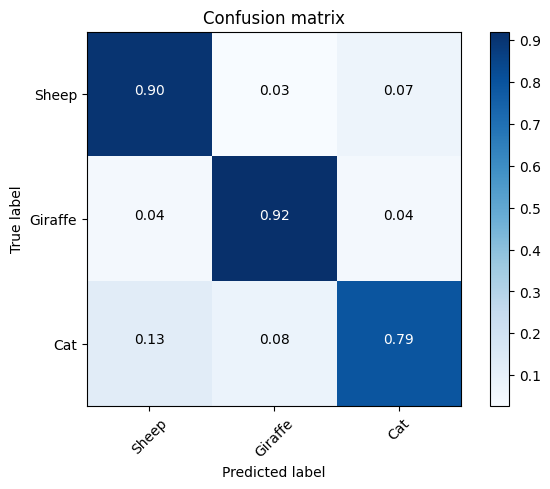

In [58]:
def train_and_return_confusion_matrix(X_tr, Y_tr, X_test, Y_test, c_val, scaler=None, degree=1):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_test_scaled = scaler.transform(X_test) if scaler else X_test
    X_train_scaled, X_test_scaled = CopyAndPolyTransform(X_train_scaled, X_test_scaled, degree)
    # train classifier
    classifier = create_classifier(X_train_scaled, Y_tr, c_val)
    # return confusion matrix
    print(accuracy(classifier, X_test_scaled, Y_test))
    return metrics.confusion_matrix(Y_test, classifier.predict(X_test_scaled))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test with best parameters
cm = train_and_return_confusion_matrix(X_train_orig, y_train, X_test_orig, y_test, c_val=0.01, scaler=MinMaxScaler(), degree=1)
plot_confusion_matrix(cm, ["Sheep", "Giraffe", "Cat"], normalize=True)

In [49]:
print("l1 scores:" ,l1_scores)
print("l2 scores:", l2_scores)

max_val = ("", 0)
for scaler in l1_scores:
  for pair in l1_scores[scaler]:
    max_val = (scaler, max(pair[1], max_val[1]))

print(max_val)

max_val = ("", 0)
for scaler in l1_scores_deg2:
  for pair in l1_scores_deg2[scaler]:
    max_val = (scaler, max(pair[1], max_val[1]))

print(max_val)

max_val = ("", 0)
for scaler in l2_scores:
  for pair in l2_scores[scaler]:
    max_val = (scaler, max(pair[1], max_val[1]))

print(max_val)

max_val = ("", 0)
for scaler in l2_scores_deg2:
  for pair in l2_scores_deg2[scaler]:
    max_val = (scaler, max(pair[1], max_val[1]))

print(max_val)

l1 scores: {'No transformation': [], 'StandardScaler': [(0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.8341666666666666, 0.8033333333333333), (0.9208333333333333, 0.8633333333333333), (0.9579166666666666, 0.8466666666666667), (0.965, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83), (0.9654166666666667, 0.83)], 'MinMaxScaler': [(0.32625, 0.3433333333333333), (0.33916666666666667, 0.33), (0.33916666666666667, 0.33), (0.7083333333333334, 0.6833333333333333), (0.8895833333333333, 0.8566666666666667), (0.9383333333333334, 0.8433333333333334), (0.9666666666666667, 0.83), (0.9683333333333334, 0.8333333333333334), (0.96875, 0.8266666666666667), (0.96875, 0.83)]}
l2 scores: {'No transformation': [(0.89, 0.8966666666666666), (0.9466666666666667, 0.8433333333333334), (0.99375, 0.8066666666666666), (0.9983333333333333, 0.7966666666666666), (0.99875, 0.79), (0.99875, 0.7866666666666666), (0.99875, 0.7833333333333333), (0.9991666666666666, 0.8

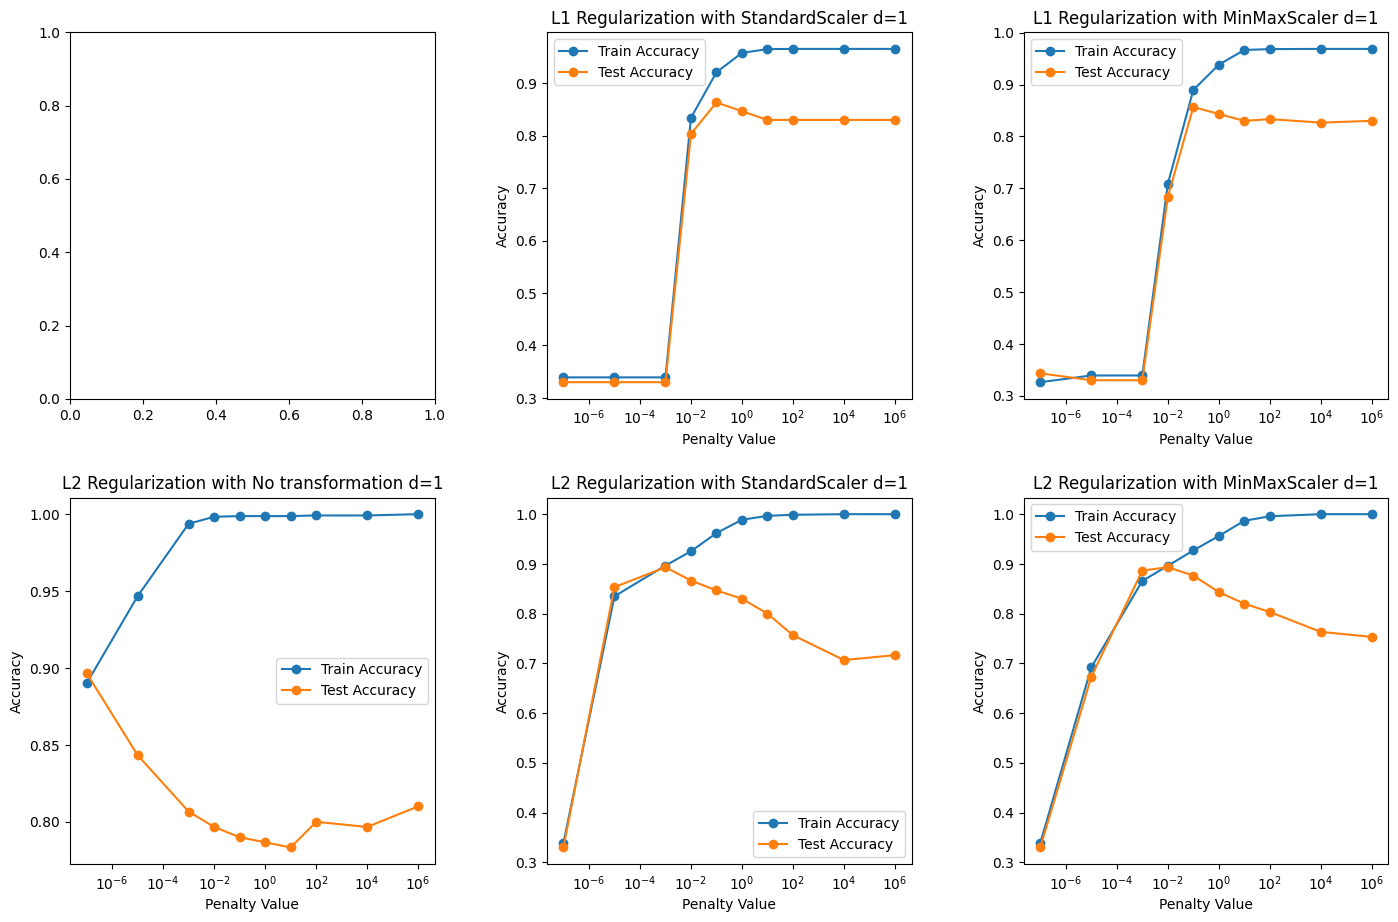

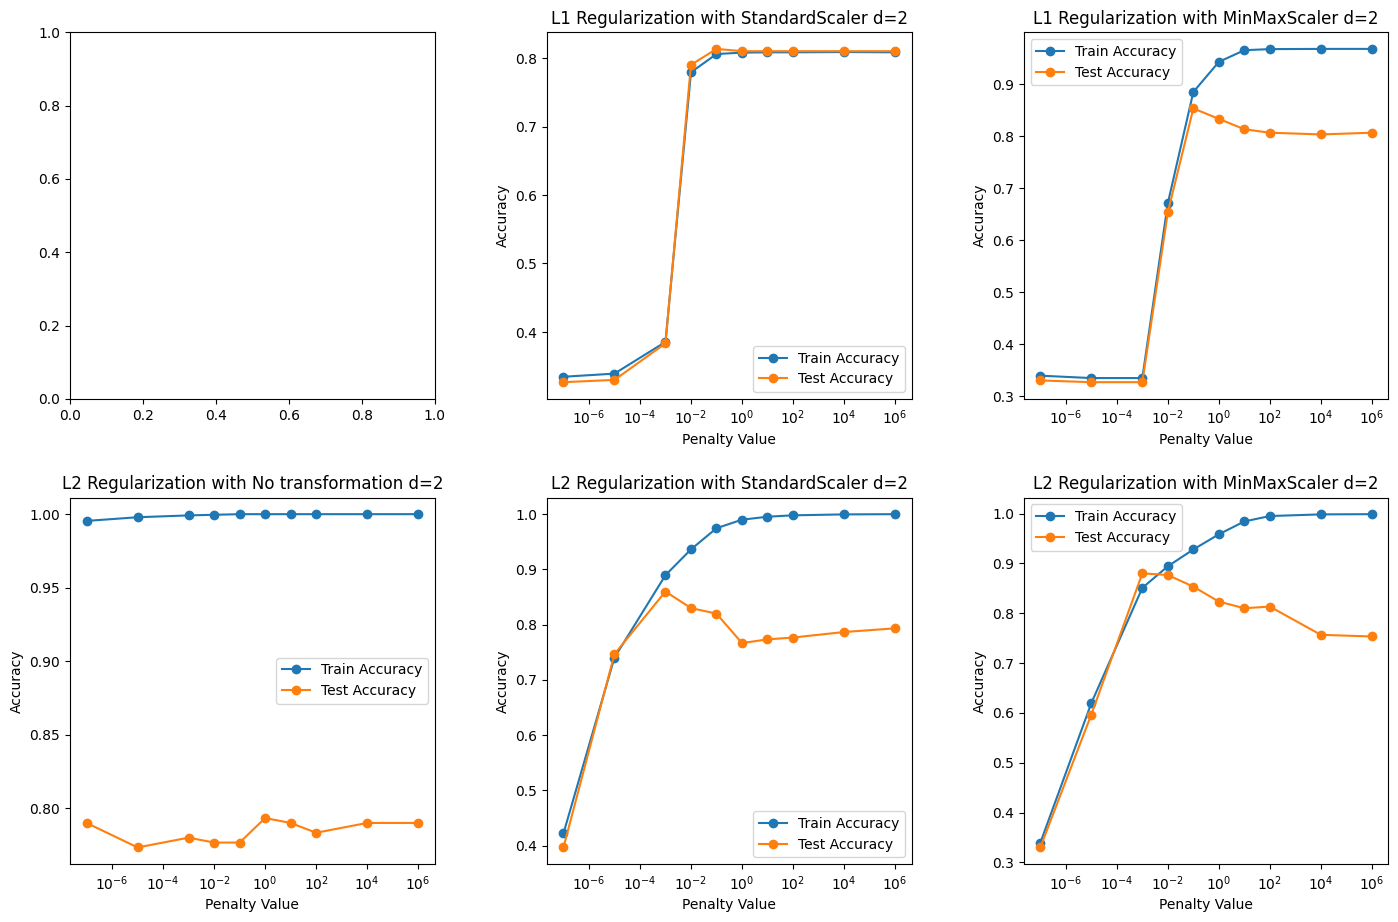

In [35]:
import matplotlib.pyplot as plt

penalty_values = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]

def plot_accuracies(l1_scores, l2_scores, degree):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.tight_layout(pad=5.0)
    
    plot_index = 0
    for regularization, scores in [('L1', l1_scores), ('L2', l2_scores)]:
        for scaler, results in scores.items():

            row = plot_index // 3
            col = plot_index % 3
            if results:
                
                train_acc, test_acc = zip(*results)
                axs[row, col].plot(penalty_values, train_acc, label='Train Accuracy', marker='o')
                axs[row, col].plot(penalty_values, test_acc, label='Test Accuracy', marker='o')
                axs[row, col].set_xscale('log')
                axs[row, col].set_xlabel('Penalty Value')
                axs[row, col].set_ylabel('Accuracy')
                axs[row, col].set_title(f'{regularization} Regularization with {scaler} d={degree}')
                axs[row, col].legend()
                
            plot_index += 1
                
    plt.show()

plot_accuracies(l1_scores, l2_scores, degree=1)
plot_accuracies(l1_scores_deg2, l2_scores_deg2, degree=2)